# Evaluation of RAG vs Baseline
This notebook evaluates the question answering results stored in `results_baseline.csv` and `results_rag.csv`.
It visualises different metrics to compare the baseline system with the RAG implementation.

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
palette = {'Baseline': 'tab:blue', 'RAG': 'tab:orange'}
heatmap_cmap = "Oranges"

baseline = pd.read_csv(Path('results_baseline.csv'))
rag = pd.read_csv(Path('results_rag.csv'))

ngram_metrics = ['precision-1','recall-1','ROUGE-1','precision-2','recall-2','ROUGE-2']
judge_metrics = ['factual_correctness','completeness','relevance','justification','depth']
metrics = ngram_metrics + judge_metrics

for df in (baseline, rag):
    for col in metrics + ['overall_score']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['paper'] = df['question_id'].str.extract(r'^(..)_')
    df['n_score'] = df[ngram_metrics].mean(axis=1)
    df['judge_score'] = df[judge_metrics].mean(axis=1)


## Average metrics across all questions

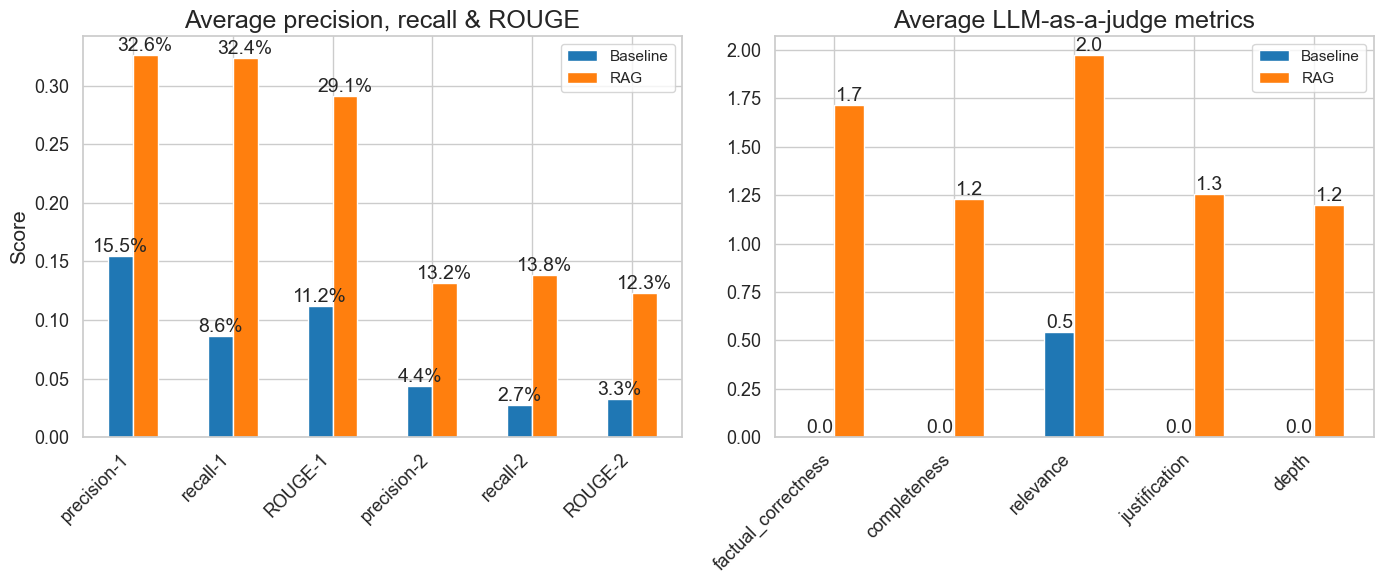

In [126]:
# Font size variables
title_fontsize = 18
label_fontsize = 15
tick_fontsize = 13
annot_fontsize = 14
legend_fontsize = 14

avg_base_n = baseline[ngram_metrics].mean()
avg_rag_n = rag[ngram_metrics].mean()
avg_base_j = baseline[judge_metrics].mean()
avg_rag_j = rag[judge_metrics].mean()
fig, axes = plt.subplots(1,2, figsize=(14,6))
pd.DataFrame({'Baseline': avg_base_n, 'RAG': avg_rag_n}).plot(
    kind='bar', ax=axes[0], color=[palette['Baseline'], palette['RAG']])
axes[0].set_ylabel('Score', fontsize=label_fontsize)
axes[0].set_title('Average precision, recall & ROUGE', fontsize=title_fontsize)
axes[0].tick_params(axis='x', labelsize=tick_fontsize)
axes[0].tick_params(axis='y', labelsize=tick_fontsize)
for p in axes[0].patches:
    height = p.get_height()
    label = f'{height:.1%}' if height <= 1 else f'{height:.1f}'
    axes[0].annotate(label, (p.get_x()+p.get_width()/2., height), 
                     ha='center', va='bottom', fontsize=annot_fontsize)
pd.DataFrame({'Baseline': avg_base_j, 'RAG': avg_rag_j}).plot(
    kind='bar', ax=axes[1], color=[palette['Baseline'], palette['RAG']])
axes[1].set_title('Average LLM-as-a-judge metrics', fontsize=title_fontsize)
axes[1].tick_params(axis='x', labelsize=tick_fontsize)
axes[1].tick_params(axis='y', labelsize=tick_fontsize)
for p in axes[1].patches:
    height = p.get_height()
    label = f'{height:.1f}' if height <= 1 else f'{height:.1f}'
    axes[1].annotate(label, (p.get_x()+p.get_width()/2., height), 
                     ha='center', va='bottom', fontsize=annot_fontsize)
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_fontsize)
plt.tight_layout()
plt.show()

## Pass/fail counts

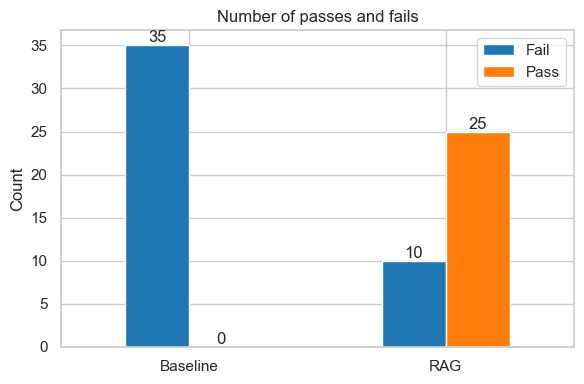

In [127]:
pass_base = baseline['pass'].astype(bool).value_counts()
pass_rag = rag['pass'].astype(bool).value_counts()
count_df = pd.DataFrame({'Baseline': pass_base, 'RAG': pass_rag}).fillna(0).T
count_df.columns = ['Fail','Pass']
ax = count_df.plot(kind='bar', stacked=False, figsize=(6,4), color=[palette['Baseline'], palette['RAG']])
ax.set_ylabel('Count')
ax.set_title('Number of passes and fails')
for c in ax.containers:
    ax.bar_label(c, label_type='edge')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Heatmaps of precision/recall/ROUGE per question

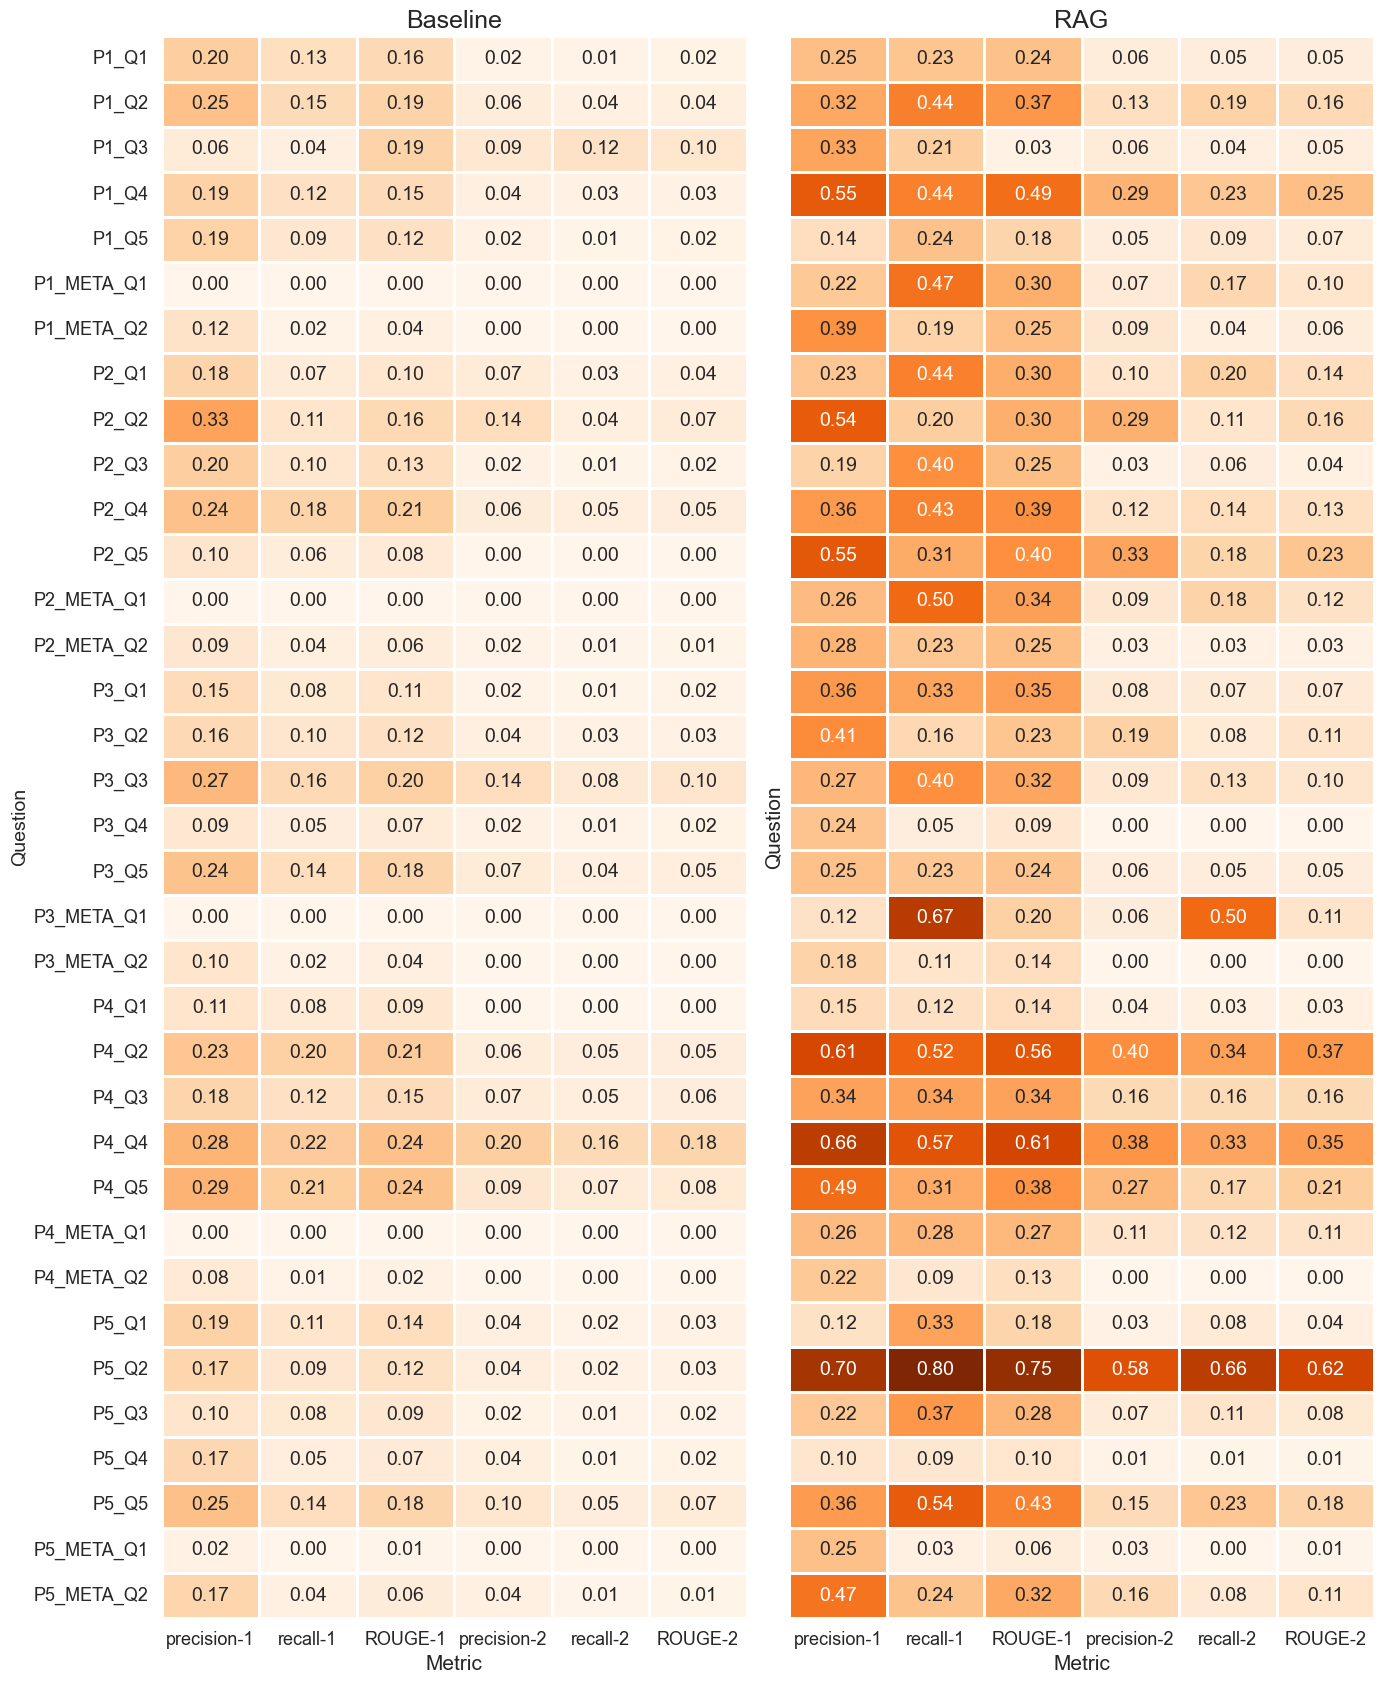

In [128]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(14, 17),  # increase height
    sharey=True, 
    gridspec_kw={'height_ratios': [1]}
)
vmin = min(baseline[ngram_metrics].min().min(), rag[ngram_metrics].min().min())
vmax = max(baseline[ngram_metrics].max().max(), rag[ngram_metrics].max().max())

sns.heatmap(
    baseline[ngram_metrics],
    ax=axes[0],
    vmin=vmin, vmax=vmax,
    cmap=heatmap_cmap,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': annot_fontsize},
    linewidths=2,
    cbar=False
)
axes[0].set_title('Baseline', fontsize=title_fontsize)
axes[0].set_xlabel('Metric', fontsize=label_fontsize)
axes[0].set_ylabel('Question', fontsize=legend_fontsize)
axes[0].set_yticklabels(baseline['question_id'], rotation=0, fontsize=tick_fontsize)
axes[0].tick_params(axis='x', labelsize=tick_fontsize)
axes[0].tick_params(axis='y', labelsize=tick_fontsize)

sns.heatmap(
    rag[ngram_metrics],
    ax=axes[1],
    vmin=vmin, vmax=vmax,
    cmap=heatmap_cmap,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': annot_fontsize},
    linewidths=2,
    cbar=False
)
axes[1].set_title('RAG', fontsize=title_fontsize)
axes[1].set_xlabel('Metric', fontsize=label_fontsize)
axes[1].set_ylabel('Question', fontsize=label_fontsize)
axes[1].set_yticklabels(rag['question_id'], rotation=0, fontsize=tick_fontsize)
axes[1].tick_params(axis='x', labelsize=tick_fontsize)
axes[1].tick_params(axis='y', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()


## Heatmaps of LLM-as-a-Judge Metrics per question

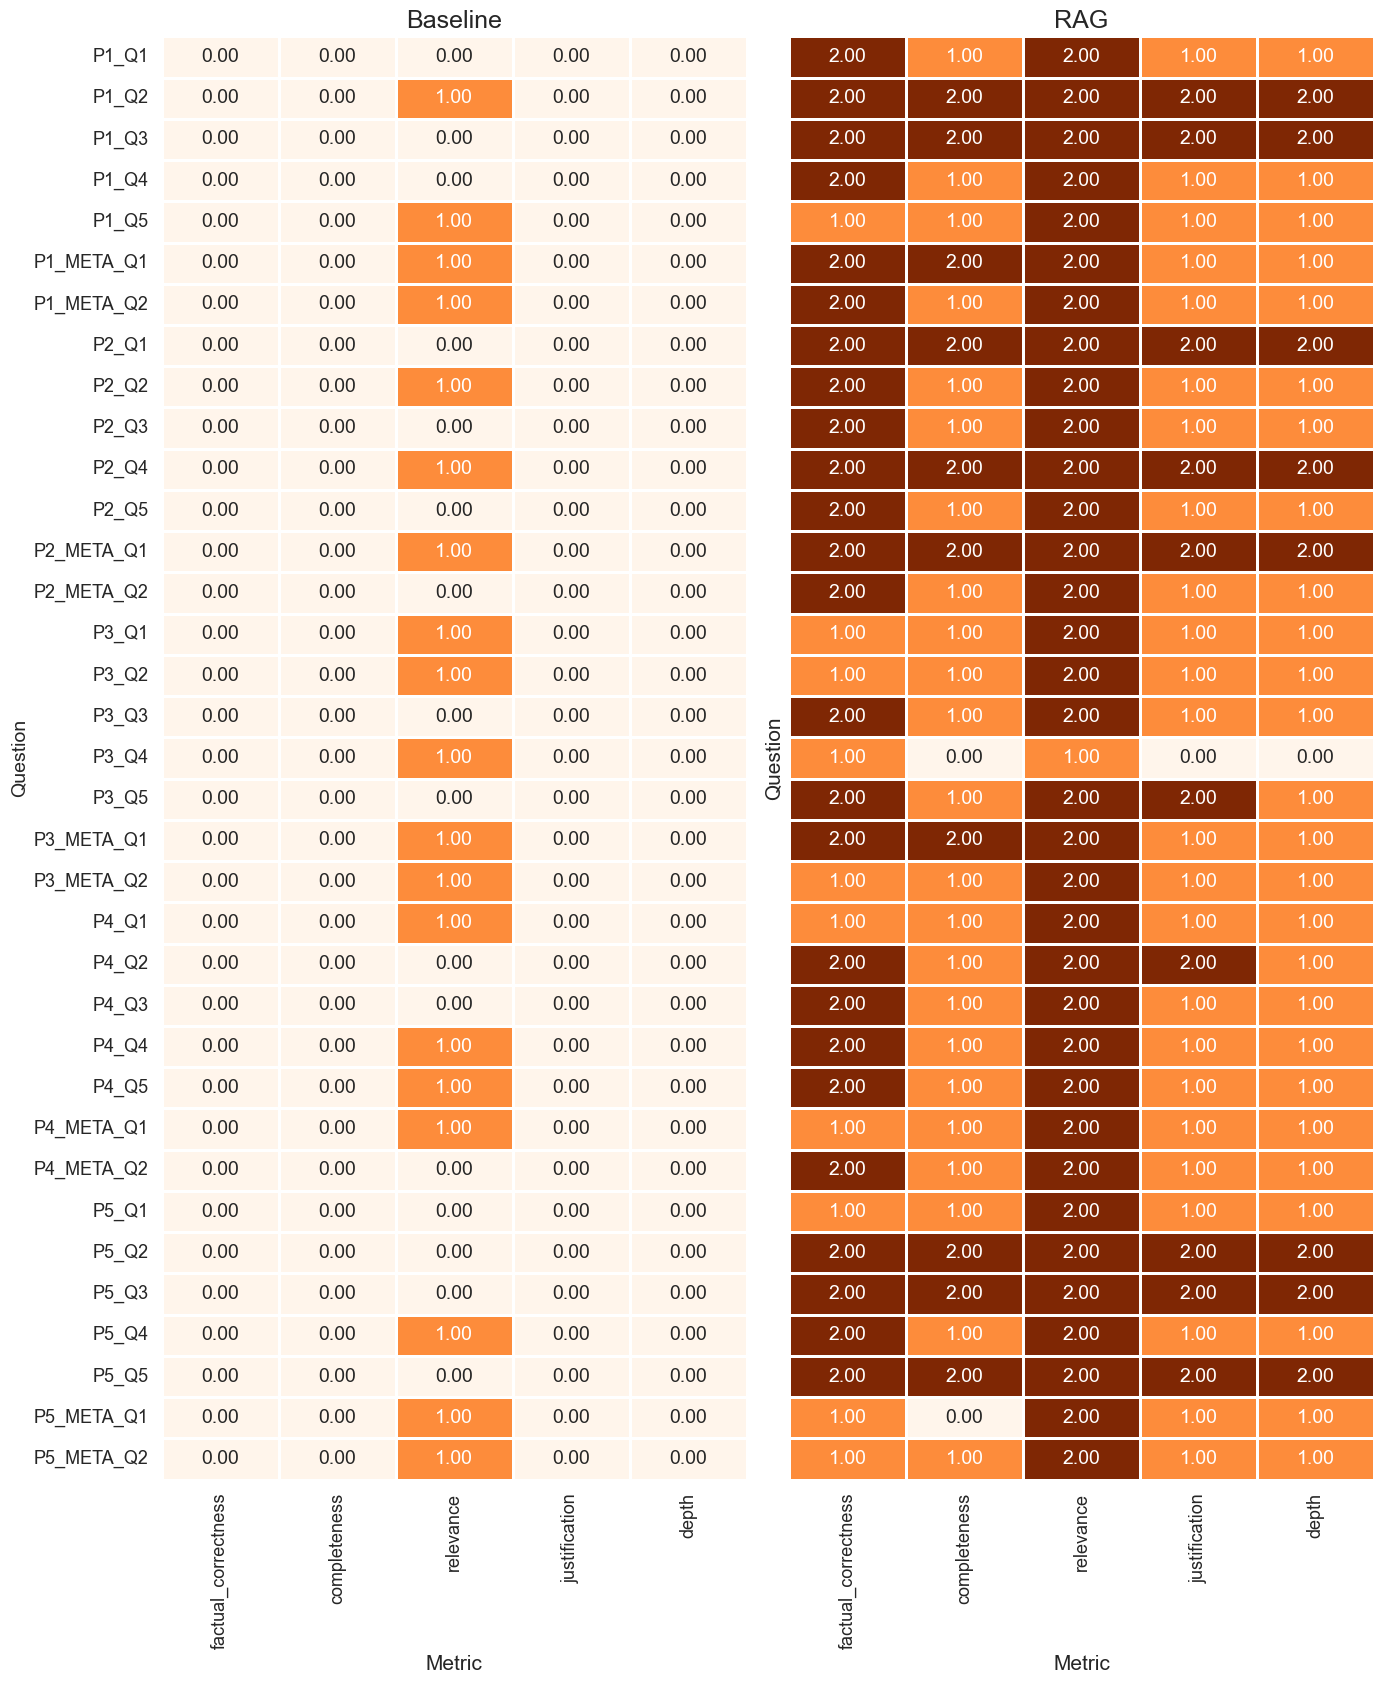

In [129]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(14, 17),  # increase height
    sharey=True, 
    gridspec_kw={'height_ratios': [1]}
)
vmin = min(baseline[judge_metrics].min().min(), rag[judge_metrics].min().min())
vmax = max(baseline[judge_metrics].max().max(), rag[judge_metrics].max().max())

sns.heatmap(
    baseline[judge_metrics],
    ax=axes[0],
    vmin=vmin, vmax=vmax,
    cmap=heatmap_cmap,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': annot_fontsize},
    linewidths=2,
    cbar=False
)
axes[0].set_title('Baseline', fontsize=title_fontsize)
axes[0].set_xlabel('Metric', fontsize=label_fontsize)
axes[0].set_ylabel('Question', fontsize=legend_fontsize)
axes[0].set_yticklabels(baseline['question_id'], rotation=0, fontsize=tick_fontsize)
axes[0].tick_params(axis='x', labelsize=tick_fontsize)
axes[0].tick_params(axis='y', labelsize=tick_fontsize)

sns.heatmap(
    rag[judge_metrics],
    ax=axes[1],
    vmin=vmin, vmax=vmax,
    cmap=heatmap_cmap,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': annot_fontsize},
    linewidths=2,
    cbar=False
)
axes[1].set_title('RAG', fontsize=title_fontsize)
axes[1].set_xlabel('Metric', fontsize=label_fontsize)
axes[1].set_ylabel('Question', fontsize=label_fontsize)
axes[1].set_yticklabels(rag['question_id'], rotation=0, fontsize=tick_fontsize)
axes[1].tick_params(axis='x', labelsize=tick_fontsize)
axes[1].tick_params(axis='y', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()


## Metrics per paper

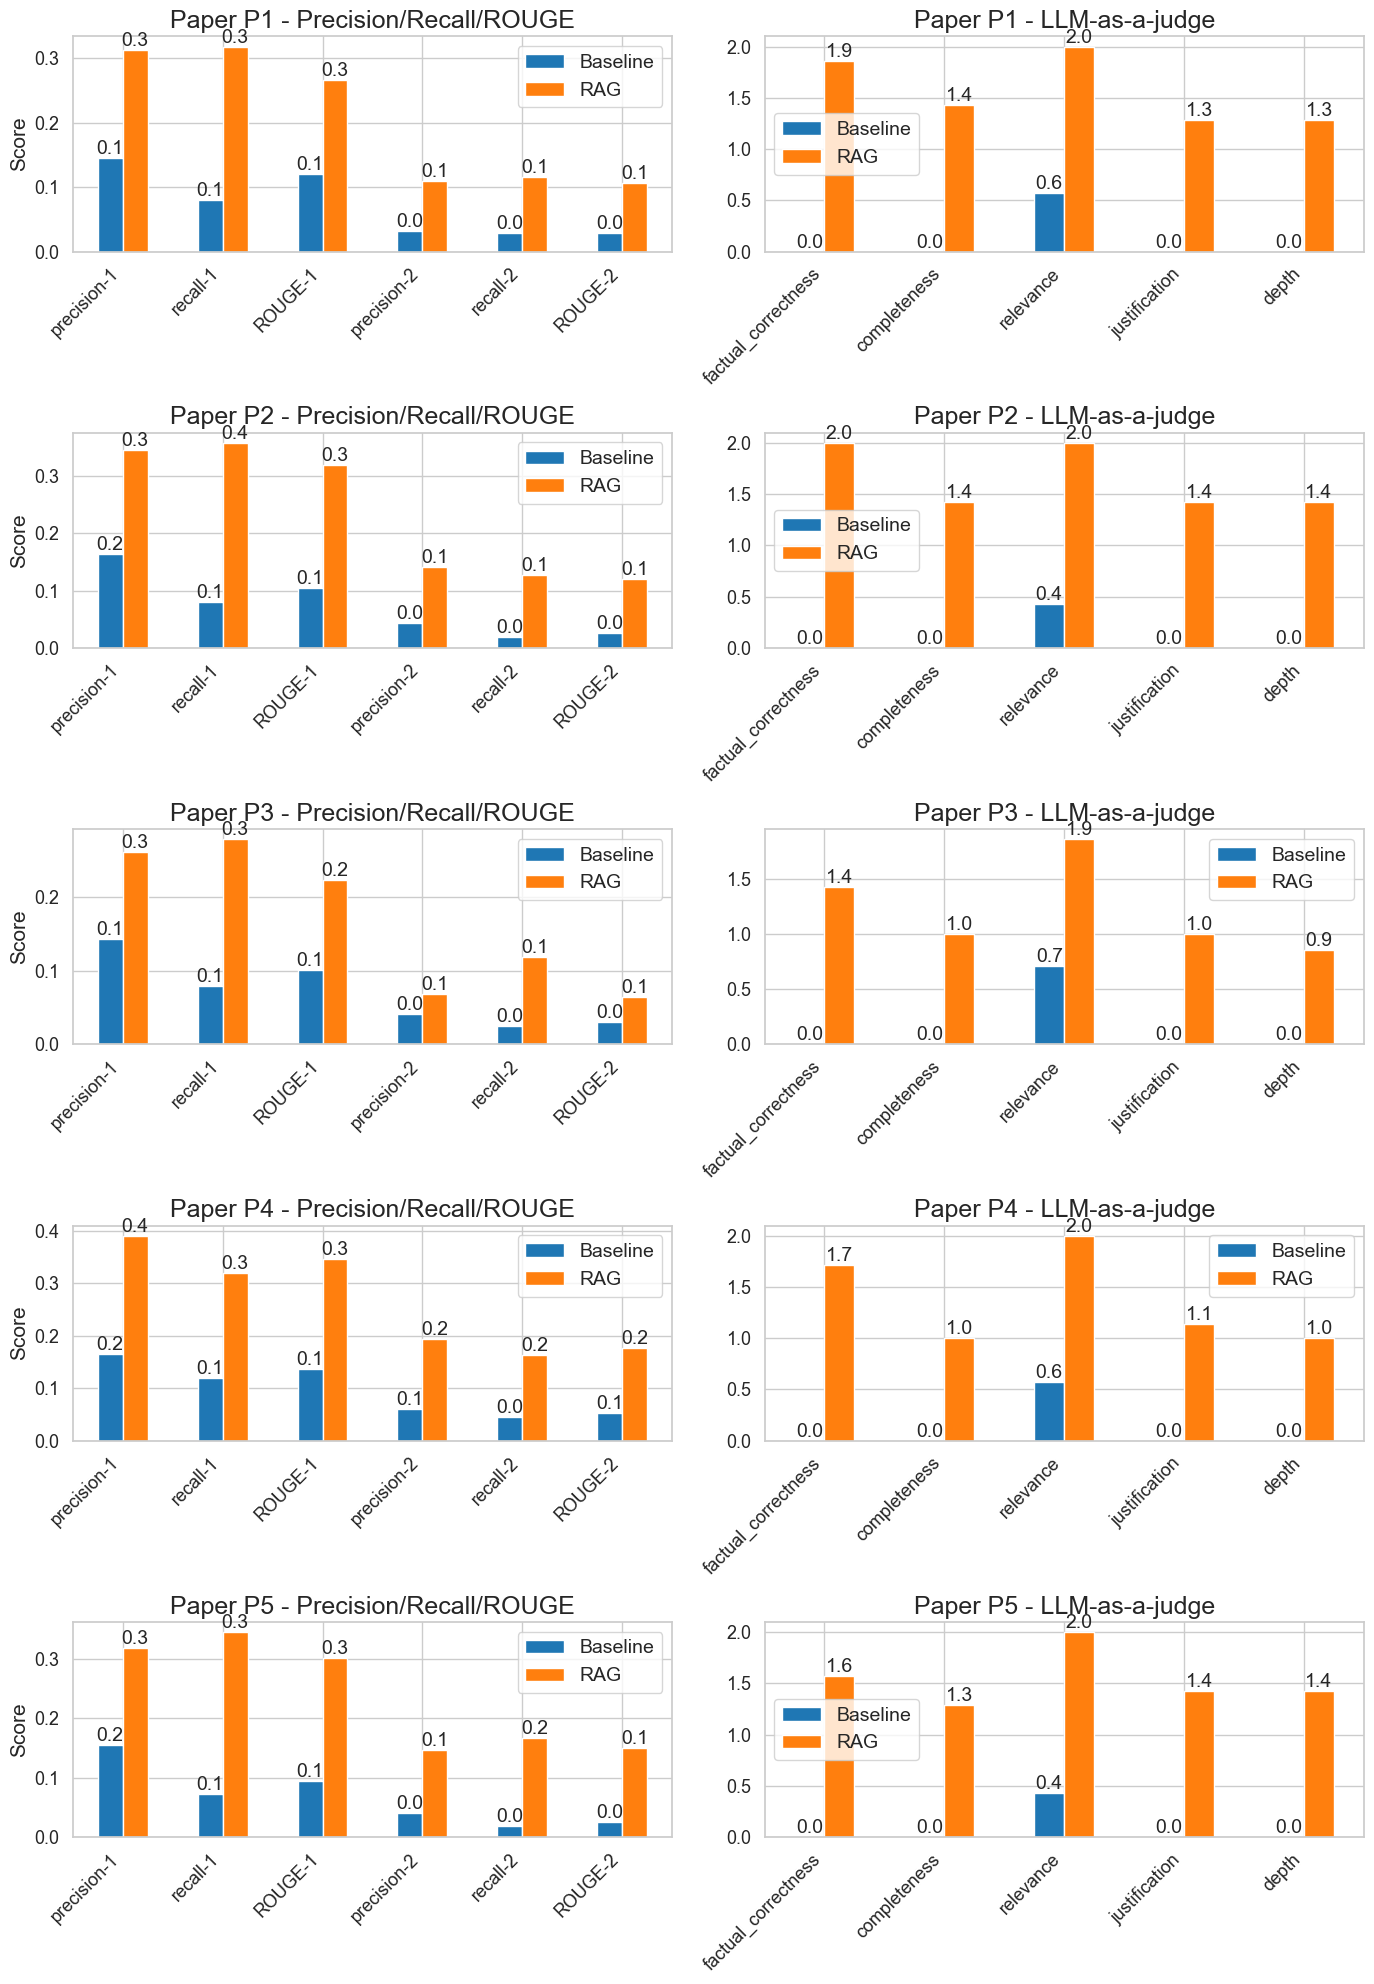

In [130]:
papers = sorted(baseline['paper'].unique())
fig, axes = plt.subplots(len(papers), 2, figsize=(14, 4*len(papers)))
for idx, paper in enumerate(papers):
    b_group = baseline[baseline['paper']==paper]
    r_group = rag[rag['paper']==paper]
    avg_b_n = b_group[ngram_metrics].mean()
    avg_r_n = r_group[ngram_metrics].mean()
    avg_b_j = b_group[judge_metrics].mean()
    avg_r_j = r_group[judge_metrics].mean()
    pd.DataFrame({'Baseline': avg_b_n, 'RAG': avg_r_n}).plot(
        kind='bar', ax=axes[idx,0], color=[palette['Baseline'], palette['RAG']])
    axes[idx,0].set_ylabel('Score', fontsize=label_fontsize)
    axes[idx,0].set_title(f'Paper {paper} - Precision/Recall/ROUGE', fontsize=title_fontsize)
    axes[idx,0].tick_params(axis='x', labelsize=tick_fontsize)
    axes[idx,0].tick_params(axis='y', labelsize=tick_fontsize)
    pd.DataFrame({'Baseline': avg_b_j, 'RAG': avg_r_j}).plot(
        kind='bar', ax=axes[idx,1], color=[palette['Baseline'], palette['RAG']])
    axes[idx,1].set_title(f'Paper {paper} - LLM-as-a-judge', fontsize=title_fontsize)
    axes[idx,1].tick_params(axis='x', labelsize=tick_fontsize)
    axes[idx,1].tick_params(axis='y', labelsize=tick_fontsize)
    for ax in axes[idx]:
        for p in ax.patches:
            height = p.get_height()
            label = f'{height:.1f}' if height <= 1 else f'{height:.1f}'
            ax.annotate(label, (p.get_x()+p.get_width()/2., height), 
                        ha='center', va='bottom', fontsize=annot_fontsize)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_fontsize)
    axes[idx,0].legend(fontsize=legend_fontsize)
    axes[idx,1].legend(fontsize=legend_fontsize)
plt.tight_layout()
plt.show()


## Correlation between LLM-as-judge metrics and n-gram metrics

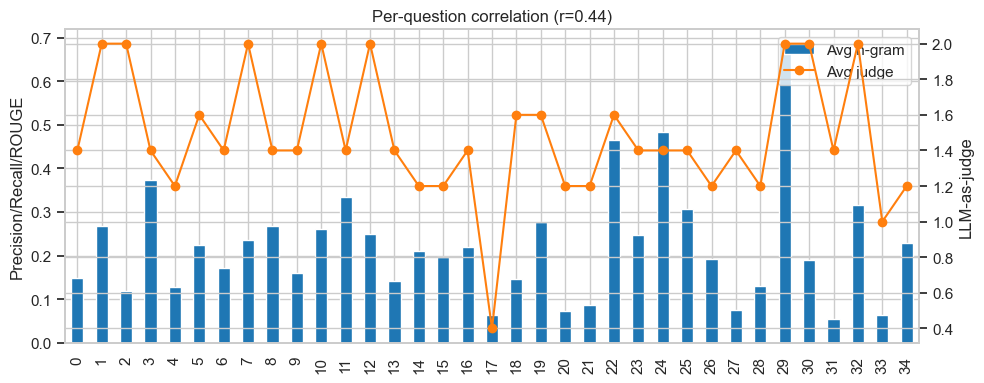

In [131]:
corr_val = rag['n_score'].corr(rag['judge_score'])
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
rag['n_score'].plot(kind='bar', ax=ax1, color=palette['Baseline'], label='Avg n-gram')
rag['judge_score'].plot(kind='line', ax=ax2, color=palette['RAG'], marker='o', label='Avg judge')
ax1.set_ylabel('Precision/Recall/ROUGE')
ax2.set_ylabel('LLM-as-judge')
ax1.set_title(f'Per-question correlation (r={corr_val:.2f})')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc='upper right')
plt.tight_layout()
plt.show()


## Additional plots

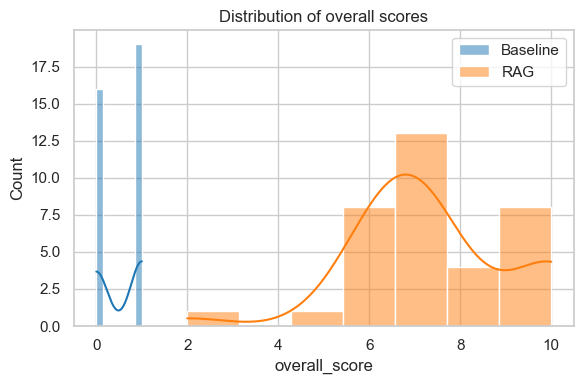

In [132]:
# Distribution of overall scores
plt.figure(figsize=(6,4))
sns.histplot(baseline['overall_score'], color=palette['Baseline'], label='Baseline', kde=True)
sns.histplot(rag['overall_score'], color=palette['RAG'], label='RAG', kde=True)
plt.legend()
plt.title('Distribution of overall scores')
plt.tight_layout()
plt.show()


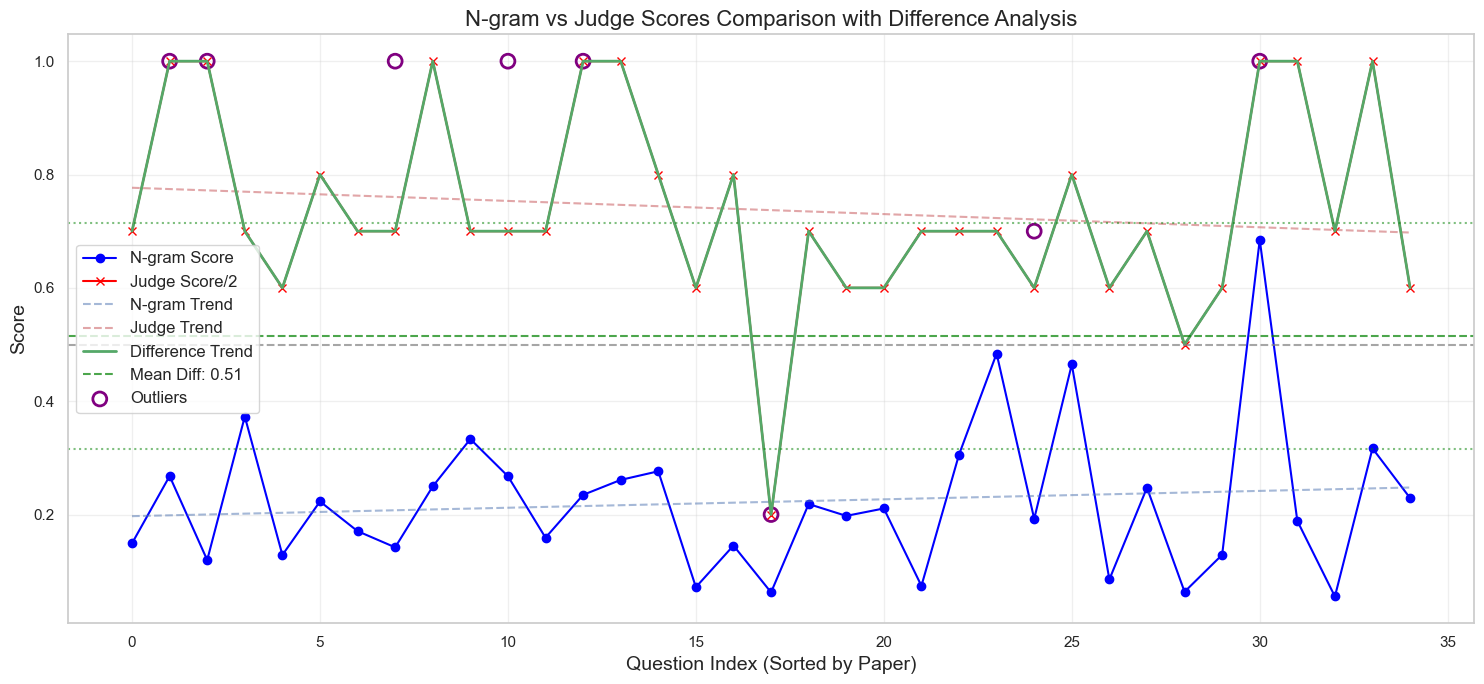

Questions with metrics difference outside ±0.2 of mean:


,Question,N-gram Metrics,Judge Metrics / 2,Difference
1,P1_Q3,0.119662,1.0,0.880338
7,P5_Q3,0.188744,1.0,0.811256
3,P2_Q1,0.234695,1.0,0.765305
2,P2_META_Q1,0.249611,1.0,0.750389
4,P2_Q4,0.261079,1.0,0.738921
0,P1_Q2,0.267835,1.0,0.732165
6,P4_Q4,0.484067,0.7,0.215933
5,P3_Q4,0.062597,0.2,0.137403


In [133]:
# Create a figure for the direct comparison with trend lines
plt.figure(figsize=(15, 7))

# Sort data by paper for consistent visualization
rag_sorted = rag.copy().sort_values('paper')
x_range = np.arange(len(rag_sorted))

# Plot n-gram scores and judge scores
plt.plot(x_range, rag_sorted['n_score'], 'o-', color='blue', label='N-gram Score')
plt.plot(x_range, rag_sorted['judge_score']/2, 'x-', color='red', label='Judge Score/2')

# Add trend lines
z1 = np.polyfit(x_range, rag_sorted['n_score'], 1)
p1 = np.poly1d(z1)
plt.plot(x_range, p1(x_range), "b--", alpha=0.5, label='N-gram Trend')

z2 = np.polyfit(x_range, rag_sorted['judge_score']/2, 1)
p2 = np.poly1d(z2)
plt.plot(x_range, p2(x_range), "r--", alpha=0.5, label='Judge Trend')

# Calculate difference between metrics
diff = rag_sorted['judge_score']/2 - rag_sorted['n_score']
mean_diff = diff.mean()

# Add difference trend line
z_diff = np.polyfit(x_range, diff, 1)
p_diff = np.poly1d(z_diff)
plt.plot(x_range, rag_sorted['n_score'] + diff, "g-", linewidth=2, label='Difference Trend')

# Add tolerance bands
plt.axhline(y=mean_diff, color='green', linestyle='--', alpha=0.7, label=f'Mean Diff: {mean_diff:.2f}')
plt.axhline(y=mean_diff+0.2, color='green', linestyle=':', alpha=0.5)
plt.axhline(y=mean_diff-0.2, color='green', linestyle=':', alpha=0.5)

# Identify outliers
outliers = rag_sorted[(diff > mean_diff+0.2) | (diff < mean_diff-0.2)]
plt.scatter(outliers.index, outliers['judge_score']/2, s=100, facecolors='none', edgecolors='purple', 
           linewidth=2, label='Outliers')

# Add reference line
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)

# Add labels and legend
plt.title('N-gram vs Judge Scores Comparison with Difference Analysis', fontsize=16)
plt.xlabel('Question Index (Sorted by Paper)', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Create DataFrame with outliers for reference
outliers_df = pd.DataFrame({
    'Question': rag_sorted.loc[outliers.index, 'question_id'].values,
    'N-gram Metrics': outliers['n_score'].values,
    'Judge Metrics / 2': outliers['judge_score'].values / 2,
    'Difference': diff[outliers.index].values
}).sort_values('Difference', ascending=False)

plt.tight_layout()
plt.show()

# Display outliers table
print("Questions with metrics difference outside ±0.2 of mean:")
outliers_df
